### Import Statements

In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the Data

In [3]:
data = pd.read_csv("../clean_data/FinalData_for_Models.csv")

In [4]:
data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)

In [5]:
data.head()

,pickup_time,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights
0,2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0
4,2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0


In [6]:
## ignoring the missing data values in 2016
data = data.loc[data.missing_dt == False, :]
data.drop("missing_dt", axis=1, inplace=True)

In [7]:
data.shape

(30647, 20)

### Creating Dummies for Weather Data

In [8]:
## for weather main
data_wm_dummies = data['weather_main'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [9]:
## for weather description
data_wd_dummies = data['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [10]:
data.drop(["weather_main", "weather_description"], axis=1, inplace=True)

In [11]:
data = pd.concat([data, data_wm_dummies], axis=1)

In [12]:
data.shape

(30647, 24)

In [13]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


** Remark : We can choose to only include weather main categories or weather description also alongwith <br> TRY BOTH OF THEM FOR MODELS **

### Modifying Boolean Data Columns (Holiday)

In [14]:
data['holiday'] = data.holiday.astype(int)

In [15]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Time Feature

In [16]:
data.rename(columns={'Hour':'HourOfDay'}, inplace=True)
data.rename(columns={'Day':'DayOfWeek'}, inplace=True)

In [17]:
data.head(2)

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [18]:
data.shape

(30647, 24)

### Drop the Pickup Time and Number of Passengers

In [19]:
data.drop(["pickup_time", "num_passengers"], axis=1, inplace=True)

## MODELS FOLLOW FROM HERE

In [20]:
## the labels (num_pickups)
num_pickups = data.num_pickups
data.drop("num_pickups", axis=1, inplace=True)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, num_pickups, random_state=0, test_size=0.1)

## LSTM RNN with Keras

In [22]:
# fix random seed for reproducibility
np.random.seed(7)

In [23]:
# convert series to supervised learning
# adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [24]:
# need to recombine X and y
features_and_target = pd.concat([data, num_pickups], axis=1)

In [25]:
features_and_target.head()

,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,num_pickups
0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,107.0
1,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,34.0
2,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,34.0
3,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0,12.0
4,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,25.0


In [26]:
values = features_and_target.values

# ensure all data is float
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values, 4, 1)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = pd.DataFrame(scaler.fit_transform(reframed))

reframed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109
0,0.321133,0.298283,0.333841,0.80,0.166667,0.038654,0.0,0.000000,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.083725,0.314709,0.288527,0.333841,0.80,0.111111,0.000000,0.0,0.043478,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.307417,0.278594,0.324566,0.57,0.166667,0.000000,0.0,0.086957,0.333333,1.0,0.0,0.000000,0.00000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.304813,0.268838,0.324566,0.8,0.166667,0.000000,0.0,0.130435,0.333333,1.0,0.0,0.255937,0.000000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.009390,0.300820,0.258904,0.324566,0.8,0.166667,0.000000,0.0,0.173913,0.333333,1.0,0.0,0.000000,0.000000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562
1,0.314709,0.288527,0.333841,0.80,0.111111,0.000000,0.0,0.043478,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.307417,0.278594,0.324566,0.57,0.166667,0.000000,0.0,0.086957,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.304813,0.268838,0.324566,0.80,0.166667,0.000000,0.0,0.130435,0.333333,1.0,0.0,0.255937,0.00000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.009390,0.300820,0.258904,0.324566,0.8,0.166667,0.000000,0.0,0.173913,0.333333,1.0,0.0,0.000000,0.000000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562,0.299430,0.258904,0.324566,0.8,0.055556,0.086972,0.0,0.217391,0.333333,1.0,0.0,0.000000,0.000000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012520
2,0.307417,0.278594,0.324566,0.57,0.166667,0.000000,0.0,0.086957,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.304813,0.268838,0.324566,0.80,0.166667,0.000000,0.0,0.130435,0.333333,1.0,0.0,0.255937,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.009390,0.300820,0.258904,0.324566,0.80,0.166667,0.000000,0.0,0.173913,0.333333,1.0,0.0,0.000000,0.00000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562,0.299430,0.258904,0.324566,0.8,0.055556,0.086972,0.0,0.217391,0.333333,1.0,0.0,0.000000,0.000000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012520,0.297347,0.258904,0.324566,0.8,0.055556,0.050465,0.0,0.260870,0.333333,1.0,0.0,0.000000,0.001860,0.025,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.010955
3,0.304813,0.268838,0.324566,0.80,0.166667,0.000000,0.0,0.130435,0.333333,1.0,0.0,0.255937,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.009390,0.300820,0.258904,0.324566,0.80,0.166667,0.000000,0.0,0.173913,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562,0.299430,0.258904,0.324566,0.80,0.055556,0.086972,0.0,0.217391,0.333333,1.0,0.0,0.000000,0.00000,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012520,0.297347,0.258904,0.324566,0.8,0.055556,0.050465,0.0,0.260870,0.333333,1.0,0.0,0.000000,0.001860,0.025,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.010955,0.291965,0.229459,0.324566,0.8,0.055556,0.256621,0.0,0.304348,0.333333,1.0,0.0,0.000000,0.001313,0.025,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016432
4,0.300820,0.258904,0.324566,0.80,0.166667,0.000000,0.0,0.173913,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562,0.299430,0.258904,0.324566,0.80,0.055556,0.086972,0.0,0.217391,0.333333,1.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012520,0.297347,0.258904,0.324566,0.80,0.055556,0.050465,0.0,0.260870,0.333333,1.0,0.0,0.000000,0.00186,0.025,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.010955,0.291965,0.229459,0.324566,0.8,0.055556,0.256621,0.0,0.304348,0.333333,1.0,0.0,0.000000,0.001313,0.025,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016432,0.293354,0.239215,0.324566,0.8,0.000000,0.285254,0.0,0.347826,0.333333,1.0,0.0,0.002345,0.007296,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.073552


In [27]:
# split into train and test sets
reframed_values = reframed.values

train_X, test_X, train_y, test_y = train_test_split(reframed_values[:,:-1], reframed_values[:,-1], 
                                                    random_state=0, test_size=0.2)

# reshape input to be 3D [samples, timesteps, features]
train_X_3d = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X_3d = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X_3d.shape, train_y.shape, test_X_3d.shape, test_y.shape)

((24514, 1, 109), (24514,), (6129, 1, 109), (6129,))


In [28]:
# design network
model = Sequential()
model.add(LSTM(50, 
               input_shape=(train_X_3d.shape[1], train_X_3d.shape[2]),
              return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(100, 
               input_shape=(train_X_3d.shape[1], train_X_3d.shape[2]),
              return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(1))

model.add(Activation('sigmoid'))

model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X_3d, train_y, epochs=100, batch_size=128,
                    validation_data=(test_X_3d, test_y), verbose=2, shuffle=False)

Train on 24514 samples, validate on 6129 samples
Epoch 1/100
 - 2s - loss: 0.1130 - val_loss: 0.0587
Epoch 2/100
 - 1s - loss: 0.0591 - val_loss: 0.0543
Epoch 3/100
 - 1s - loss: 0.0558 - val_loss: 0.0535
Epoch 4/100
 - 1s - loss: 0.0534 - val_loss: 0.0525
Epoch 5/100
 - 1s - loss: 0.0513 - val_loss: 0.0500
Epoch 6/100
 - 1s - loss: 0.0494 - val_loss: 0.0495
Epoch 7/100
 - 1s - loss: 0.0480 - val_loss: 0.0456
Epoch 8/100
 - 1s - loss: 0.0471 - val_loss: 0.0466
Epoch 9/100
 - 1s - loss: 0.0465 - val_loss: 0.0454
Epoch 10/100
 - 1s - loss: 0.0461 - val_loss: 0.0454
Epoch 11/100
 - 1s - loss: 0.0456 - val_loss: 0.0451
Epoch 12/100
 - 1s - loss: 0.0452 - val_loss: 0.0440
Epoch 13/100
 - 1s - loss: 0.0448 - val_loss: 0.0454
Epoch 14/100
 - 1s - loss: 0.0444 - val_loss: 0.0442
Epoch 15/100
 - 1s - loss: 0.0441 - val_loss: 0.0428
Epoch 16/100
 - 1s - loss: 0.0439 - val_loss: 0.0424
Epoch 17/100
 - 1s - loss: 0.0438 - val_loss: 0.0428
Epoch 18/100
 - 1s - loss: 0.0433 - val_loss: 0.0423
Epoch 

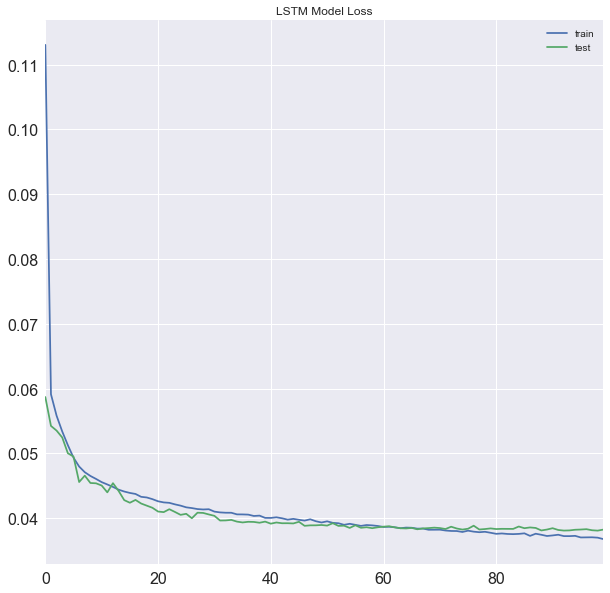

In [29]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');
plt.savefig("../images/lstm_model_loss.png")

In [30]:
# make a prediction
yhat = model.predict(test_X_3d)

# reshape back to 2d
test_X = test_X_3d.reshape((test_X_3d.shape[0], test_X_3d.shape[2]))

In [31]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [32]:
# calculate r2
r2_score(test_y, yhat)

0.93649713685593361

In [33]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.219


In [34]:
results = pd.DataFrame()
results['prediction'] = inv_yhat
results['actual'] = inv_y

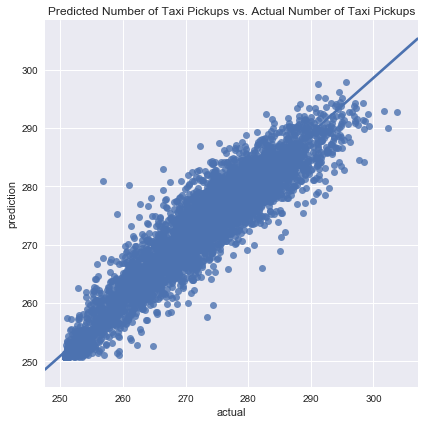

In [36]:
import seaborn as sns
sns.lmplot(x='actual',y='prediction',data=results,fit_reg=True, size=6)
plt.title("Predicted Number of Taxi Pickups vs. Actual Number of Taxi Pickups")
plt.tight_layout()
plt.savefig("../images/lstm_model_pred_actual.png")

In [37]:
from keras.utils import plot_model
plot_model(model, to_file='../images/lstm_model.png')